## 导包和数据集

In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784') #28x28
# mnist = datasets.load_digits() #尺寸8x8的toy版mnist，

In [2]:
X, y = mnist.data, mnist.target
# 按6:1划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
def show_data_count(data): # 查看标签数量
    unique, counts = np.unique(data, return_counts=True)
    return dict(zip(unique, counts))
print(f"y_train:{show_data_count(y_train)}\n")
print(f"y_test:{show_data_count(y_test)}\n")


(60000, 784) (60000,)
(10000, 784) (10000,)
y_train:{'0': 5920, '1': 6725, '2': 6023, '3': 6107, '4': 5918, '5': 5376, '6': 5915, '7': 6238, '8': 5856, '9': 5922}

y_test:{'0': 983, '1': 1152, '2': 967, '3': 1034, '4': 906, '5': 937, '6': 961, '7': 1055, '8': 969, '9': 1036}



In [3]:
def sp_noise(image,prob):
  import numpy as np
  import random
  output = np.zeros(image.shape,np.uint8)
  thres = 1 - prob 
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      rdn = random.random()
      if rdn < prob:
        output[i][j] = 0
      elif rdn > thres:
        output[i][j] = 255
      else:
        output[i][j] = image[i][j]
  return output

def add_sp_data(data):
    # 给数据集加椒盐噪声
    sp_data_list = []
    for i in data:
        img = i.reshape(28, 28)
        sp_img = sp_noise(img,0.14)
        # np.array()
        sp_data_list.append(sp_img.flatten())
    return sp_data_list

In [4]:
Xsp_train,Xsp_test = np.array(add_sp_data(X_train)),np.array(add_sp_data(X_test))

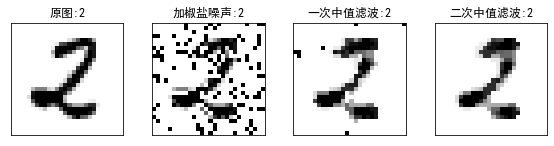

In [23]:
# 由于mnist数据集太简单了，给它加点噪声
import cv2
def show_digit(titles,images,rows,cols,size,savename=None):
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=size,sharex='all', sharey='all')
    ax = ax.flatten()
    for i in range(rows*cols):
        ax[i].set_title(f"{titles[i]}")
        ax[i].imshow(images[i],cmap=matplotlib.cm.binary,interpolation="nearest")
        # ax[i].axis("off")
    ax[0].set_xticks([]),ax[0].set_yticks([])
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()

i = 666
truth = y_train[i]
img = X_train[i].reshape(28,28)
sp_img = Xsp_train[i].reshape(28,28)
medianBlur_img = cv2.medianBlur(sp_img,3)
medianBlur_img2 = cv2.medianBlur(medianBlur_img,3)


titles = [f"原图:{truth}",f"加椒盐噪声:{truth}",f"一次中值滤波:{truth}",f"二次中值滤波:{truth}"]
images = [img,sp_img,medianBlur_img,medianBlur_img2]


show_digit(titles,images,1,4,(8,2),"图像分类_噪声滤波前后对比图.png")

In [45]:

import numpy as np
import cv2
from matplotlib import pyplot as plt
def double_median_blur(sp_img):
    medianBlur_img = cv2.medianBlur(sp_img,3)
    medianBlur_img2 = cv2.medianBlur(medianBlur_img,3)
    return medianBlur_img2

def filter_bank(data):
    # 给数据集做两次中值滤波
    clean_data_list = []
    for i in data:
        img = i.reshape(28, 28)
        de_sp_img = double_median_blur(img)
        clean_data_list.append(de_sp_img.flatten())
    return clean_data_list

In [46]:
XX_train,XX_test = np.array(filter_bank(Xsp_train)),np.array(filter_bank(Xsp_test))

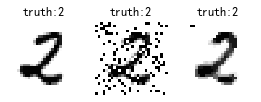

In [49]:
i = 666
truth = y_train[i]
img = X_train[i].reshape(28,28)
sp_img = Xsp_train[i].reshape(28,28)
de_sp_img = XX_train[i].reshape(28,28)
plt.subplot(141); plot_digit(img); plt.title(f"truth:{truth}")
plt.subplot(142); plot_digit(sp_img); plt.title(f"truth:{truth}")
plt.subplot(143); plot_digit(de_sp_img); plt.title(f"truth:{truth}")
plt.show()

## K-Nearest-Neighbors

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
clf = KNeighborsClassifier(n_neighbors=11).fit(XX_train,y_train)
preds = clf.predict(XX_test)
print("有噪声情况下，做两次中值滤波后训练的结果\n")
print(f"评价结果：\n{classification_report(y_test,preds)}")

做两次中值滤波后训练的结果

评价结果：
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       983
           1       0.85      0.99      0.91      1152
           2       0.95      0.91      0.93       967
           3       0.93      0.88      0.90      1034
           4       0.88      0.91      0.89       906
           5       0.92      0.92      0.92       937
           6       0.94      0.96      0.95       961
           7       0.91      0.93      0.92      1055
           8       0.97      0.82      0.89       969
           9       0.88      0.87      0.87      1036

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
clf = KNeighborsClassifier(n_neighbors=11).fit(Xsp_train,y_train)
preds = clf.predict(Xsp_test)
print("有噪声情况下，做不做任何处理直接训练的结果\n")
print(f"评价结果：\n{classification_report(y_test,preds)}")

有噪声情况下，做不做任何处理直接训练的结果

评价结果：
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       983
           1       0.75      0.99      0.85      1152
           2       0.95      0.84      0.89       967
           3       0.89      0.86      0.87      1034
           4       0.89      0.84      0.86       906
           5       0.92      0.84      0.88       937
           6       0.93      0.95      0.94       961
           7       0.89      0.90      0.89      1055
           8       0.95      0.74      0.83       969
           9       0.81      0.87      0.84      1036

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
clf = KNeighborsClassifier(n_neighbors=11).fit(X_train,y_train)
preds = clf.predict(X_test)
print("无噪声情况下，不做filter bank直接训练的结果\n")
# print(f"preds:{preds}\n")
print(f"评价结果：\n{classification_report(y_test,preds)}")

无噪声情况下，不做filter bank直接训练的结果

评价结果：
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       983
           1       0.94      0.99      0.97      1152
           2       0.97      0.96      0.97       967
           3       0.95      0.96      0.96      1034
           4       0.98      0.96      0.97       906
           5       0.96      0.96      0.96       937
           6       0.98      0.98      0.98       961
           7       0.96      0.97      0.96      1055
           8       0.99      0.91      0.95       969
           9       0.95      0.96      0.95      1036

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.97      0.96      0.96     10000



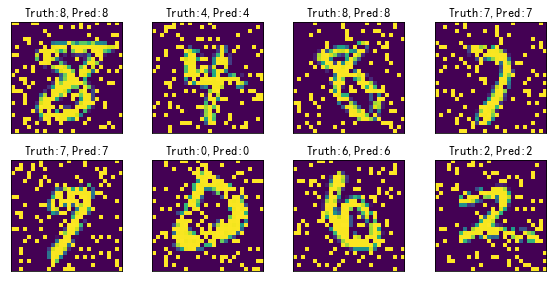

In [30]:
import matplotlib.pyplot as plt
preds = clf.predict(Xsp_test)
# 可视化样本，下面是输出了训练集中前4个样本
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,4),sharex='all', sharey='all')
ax = ax.flatten()
for i in range(8):
    img = Xsp_test[i].reshape(28, 28)
    # ax[i].imshow(img,cmap='Greys')
    ax[i].set_title(f"Truth:{y_test[i]},Pred:{preds[i]}")
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig("图像分类_部分噪声数据集.png")
plt.show()

In [57]:
print(f"用干净数据训练的模型测评噪声数据的结果：\n{classification_report(y_test,preds)}")

用干净数据训练的模型测评噪声数据的结果：
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       983
           1       0.94      0.99      0.97      1152
           2       0.97      0.94      0.95       967
           3       0.95      0.94      0.94      1034
           4       0.96      0.95      0.95       906
           5       0.95      0.96      0.95       937
           6       0.97      0.99      0.98       961
           7       0.96      0.96      0.96      1055
           8       0.98      0.90      0.94       969
           9       0.93      0.95      0.94      1036

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
# KNN算法流程：先计算测试数据与各个训练数据之间的距离，对距离从小到大排序，选取距离最小的K个点，确定前K个点类别的出现频率，出现频率最高的类别作为输出的预测类别。

In [29]:
# 优化
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,f1_score
# 以F1分数为指标，找邻居数K的最佳值
kVals = np.arange(3,50,2)
acc_score_list = []
for k in kVals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_score_list.append(acc)
    print("K = "+str(k)+"; acc: "+str(acc))

理论参考[知乎:深度学习开端｜全连接神经网络](https://zhuanlan.zhihu.com/p/104576756)

![img](https://pic3.zhimg.com/80/v2-8d0d03d122da50d62f9ec5567883a4ba_720w.jpg)

In [31]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Input,Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from keras.utils import np_utils

In [ ]:
# 导入Keras自带的划分好的mnist数据集
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 整理数据输入格式
img_rows, img_cols=28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols).astype('float32')
X_train /= 255
X_test /= 255
# 转换为类别类型
y_train_1 = np_utils.to_categorical(y_train)
y_test_1 = np_utils.to_categorical(y_test)

In [ ]:
# 全连接
model = Sequential()
model.add(Dense(512, input_dim = 28 * 28, activation= 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
# 编译
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# 展示模型架构
model.summary()

In [ ]:
model.fit(X_train, y_train_1, batch_size=256, epochs=14)

In [ ]:
# 简单评估
score = model.evaluate(X_test, y_test_1)
print(f'loss={score[0]}\naccuracy={score[1]}')

In [ ]:
# 使用sklearn的评估函数
from sklearn.metrics import classification_report,accuracy_score
preds = model.predict_classes(X_test)
print(f"模型测评结果：\n{classification_report(y_test,preds)}")